In [2]:
! pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 9.5 MB/s eta 0:00:00


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from umap.umap_ import UMAP
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pytorch_metric_learning import losses

In [5]:
# Set global parameters
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

    print(device)

cuda


In [6]:
# Load and preprocess CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the size for the train and validation splits
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Calculate the class weights
class_counts = [0] * 10  # 10 classes in CIFAR10
for _, label in train_dataset:
    class_counts[label] += 1

total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
# Create a list of sample weights based on class weights
sample_weights = [class_weights[label] for _, label in train_dataset]
# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

# Create data loaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

100%|██████████| 170498071/170498071 [00:11<00:00, 14248143.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Check class distribution in each batch
num_classes = 10  # Assuming 10 classes in CIFAR10
batch_class_counts = [0] * num_classes

for batch_images, batch_labels in train_loader:
    for label in batch_labels:
        batch_class_counts[label] += 1

    # Print class counts for the current batch
    print("Class counts in the current batch:")
    for i, count in enumerate(batch_class_counts):
        print(f"Class {i}: {count}")

    # Reset batch class counts for the next batch
    batch_class_counts = [0] * num_classes

# Print overall class distribution in the training dataset
print("\nOverall class distribution in the training dataset:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count}")

Class counts in the current batch:
Class 0: 14
Class 1: 16
Class 2: 13
Class 3: 16
Class 4: 12
Class 5: 14
Class 6: 9
Class 7: 8
Class 8: 14
Class 9: 12
Class counts in the current batch:
Class 0: 7
Class 1: 14
Class 2: 13
Class 3: 16
Class 4: 12
Class 5: 18
Class 6: 11
Class 7: 10
Class 8: 16
Class 9: 11
Class counts in the current batch:
Class 0: 11
Class 1: 9
Class 2: 11
Class 3: 15
Class 4: 9
Class 5: 13
Class 6: 10
Class 7: 23
Class 8: 15
Class 9: 12
Class counts in the current batch:
Class 0: 17
Class 1: 19
Class 2: 13
Class 3: 13
Class 4: 11
Class 5: 9
Class 6: 8
Class 7: 13
Class 8: 12
Class 9: 13
Class counts in the current batch:
Class 0: 12
Class 1: 13
Class 2: 21
Class 3: 14
Class 4: 13
Class 5: 6
Class 6: 13
Class 7: 12
Class 8: 13
Class 9: 11
Class counts in the current batch:
Class 0: 20
Class 1: 11
Class 2: 12
Class 3: 11
Class 4: 17
Class 5: 8
Class 6: 13
Class 7: 15
Class 8: 8
Class 9: 13
Class counts in the current batch:
Class 0: 5
Class 1: 16
Class 2: 9
Class 3: 12

## Help functions

### Training function

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()
    
    return train_losses, val_losses

### KNN test function

In [10]:
# Extract features from the images using the pre-trained model
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.cuda()
            features_batch = model(images).cpu().numpy()
            features.append(features_batch)
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels



# Test the model on original test data using KNN
def test_model_knn(model, knn_classifier, dataloader):
    model.eval()
    features, labels = extract_features(model, dataloader)
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on original test data using KNN: {accuracy:.2f}%")



# Test the model on adversarial test data using KNN
def test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device):
    model.eval()
    # Convert adversarial_images to PyTorch tensor and move it to the device
    adversarial_images_tensor = torch.tensor(adversarial_images, dtype=torch.float32).to(device)
    # Detach the tensor from the computation graph before calling .numpy()
    features = model(adversarial_images_tensor).detach().cpu().numpy()
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on adversarial test data using KNN: {accuracy:.2f}%")

### Visualize feature map

In [30]:
def plot_umap(model, dataloader, device):
    # Set model to evaluation mode
    model.eval()

    # Define a function to get embeddings
    def get_embeddings(model, dataloader):
        embeddings = []
        labels = []
        with torch.no_grad():
            for images, targets in dataloader:
                images = images.to(device)
                outputs = model(images)
                embeddings.append(outputs.cpu().numpy())
                labels.append(targets.cpu().numpy())
        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        return embeddings, labels

    # Get embeddings from the dataloader
    embeddings_test, labels_test = get_embeddings(model, dataloader)

    # Use UMAP to reduce dimensionality
    reducer = UMAP()
    embedding_umap_test = reducer.fit_transform(embeddings_test)

    # Plot UMAP visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_umap_test[:, 0], embedding_umap_test[:, 1], c=labels_test, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('UMAP Visualization of original data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

### Generate adverserial samples

In [28]:
def combine_fgsm_and_noise(model, images, labels, eps, noise_factor):
    # Generate adversarial images using CleverHans's Fast Gradient Sign Method (FGSM)
    attack_images = fast_gradient_method(model, images, eps, np.inf, targeted=False, y=labels)

    # Detach the images to prevent further gradient computation
    attack_images = attack_images.detach()

    # Convert images to numpy to add noise
    attack_images_np = attack_images.cpu().numpy()

    # Add Gaussian noise
    attack_images_np += noise_factor * np.random.normal(loc=0, scale=1, size=attack_images_np.shape)
    attack_images_np = np.clip(attack_images_np, 0, 1)

    # Convert back to torch tensor
    attack_images_with_noise = torch.tensor(attack_images_np, requires_grad=False).to(device)

    return attack_images_with_noise

# Parameters for FGSM and noise
eps = 0.1
noise_factor = 0.05

# 1. Original dataset/Cross Entropy

### 1.1. Train original data/Cross entropy

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


Epoch [1/10], Training Loss: 0.8775, Training Accuracy: 70.72%, Validation Loss: 0.7834, Validation Accuracy: 74.00%
Epoch [2/10], Training Loss: 0.5337, Training Accuracy: 82.36%, Validation Loss: 0.7230, Validation Accuracy: 77.01%
Epoch [3/10], Training Loss: 0.4157, Training Accuracy: 86.41%, Validation Loss: 0.7699, Validation Accuracy: 75.76%
Epoch [4/10], Training Loss: 0.3367, Training Accuracy: 88.97%, Validation Loss: 0.6452, Validation Accuracy: 79.56%
Epoch [5/10], Training Loss: 0.2643, Training Accuracy: 91.46%, Validation Loss: 0.6878, Validation Accuracy: 79.81%
Epoch [6/10], Training Loss: 0.2223, Training Accuracy: 92.84%, Validation Loss: 0.7583, Validation Accuracy: 78.56%
Epoch [7/10], Training Loss: 0.1881, Training Accuracy: 93.91%, Validation Loss: 0.6878, Validation Accuracy: 80.42%
Epoch [8/10], Training Loss: 0.1566, Training Accuracy: 94.95%, Validation Loss: 0.7285, Validation Accuracy: 80.15%
Epoch [9/10], Training Loss: 0.1341, Training Accuracy: 95.61%, 

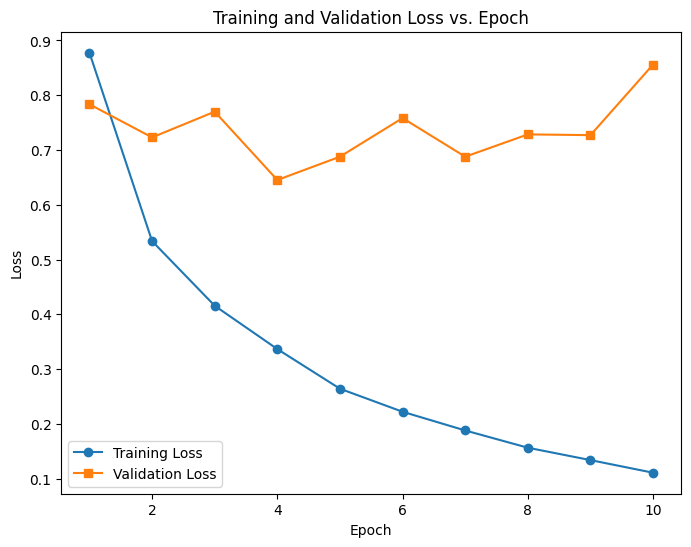

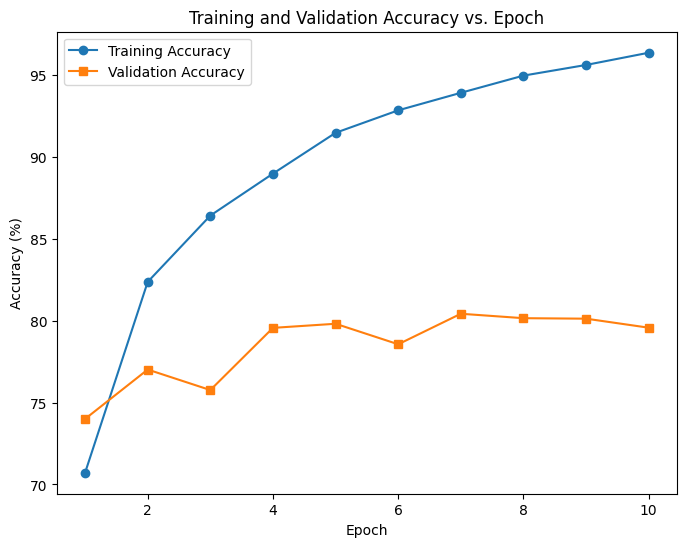

In [13]:
# Setup
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

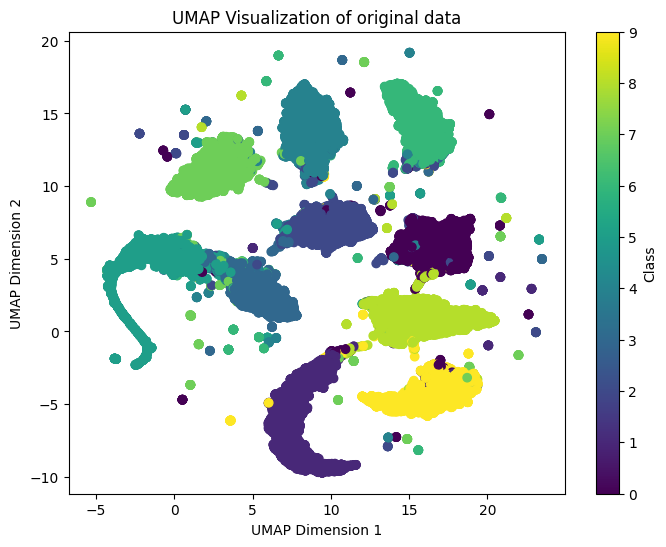

In [36]:
# Call the function to extract and visualize features
plot_umap(model, train_loader, device)

### 1.2. FGSM

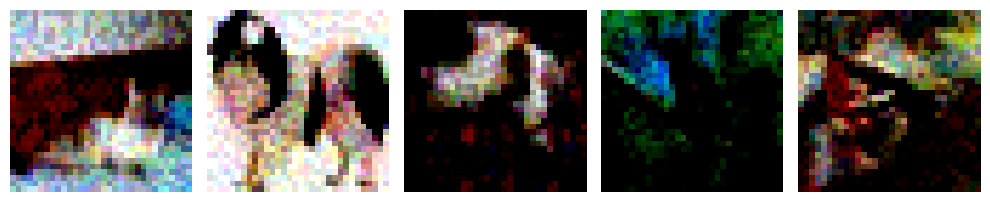

In [14]:
model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

# Display some adversarial images
num_images = 5
indices = np.random.choice(len(adversarial_images), num_images, replace=False)
plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.transpose(adversarial_images[index], (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.3. Test original data/Cross entropy

In [16]:
train_features, train_labels = extract_features(model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(model, knn_classifier, test_loader)
test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 80.19%
Accuracy on adversarial test data using KNN: 11.41%


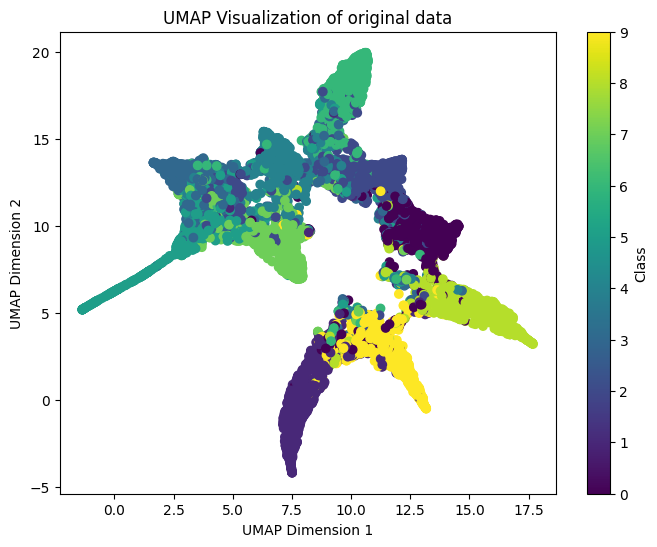

In [31]:
# Call the function to extract and visualize features
plot_umap(model, test_loader, device)

# 2. Agumented data/Cross entropy

### 2.1. Train agumented data/Cross entropy

In [18]:
# Function to apply FGSM attack with 50% probability to each batch
def apply_fgsm(model, images, labels, criterion, eps):
    # Enable gradients for images
    images.requires_grad = True

    # Perform FGSM attack only if gradients are enabled
    if images.requires_grad:
        outputs = model(images)
        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()
        attack_images = images + eps * images.grad.sign()
        attack_images = torch.clamp(attack_images, 0, 1)
    else:
        attack_images = images

    return attack_images

# Modified training function to apply FGSM with 50% probability
def train_with_fgsm(model, train_loader, val_loader, criterion, optimizer, device, epochs, eps=0.1):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Apply FGSM attack with 50% probability
            if torch.rand(1) < 0.5:
                images = apply_fgsm(model, images, labels, criterion, eps)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        # Validation loop
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Note: No FGSM attack is applied during validation
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, 's-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 1.4345, Validation Loss: 0.9549
Epoch [2/10], Training Loss: 1.1262, Validation Loss: 0.9702
Epoch [3/10], Training Loss: 0.9854, Validation Loss: 0.8992
Epoch [4/10], Training Loss: 1.0078, Validation Loss: 0.6854
Epoch [5/10], Training Loss: 0.7925, Validation Loss: 0.6499
Epoch [6/10], Training Loss: 0.8204, Validation Loss: 0.7098
Epoch [7/10], Training Loss: 0.7210, Validation Loss: 0.7223
Epoch [8/10], Training Loss: 0.6535, Validation Loss: 0.6929
Epoch [9/10], Training Loss: 0.6178, Validation Loss: 0.7054
Epoch [10/10], Training Loss: 0.5756, Validation Loss: 0.7081


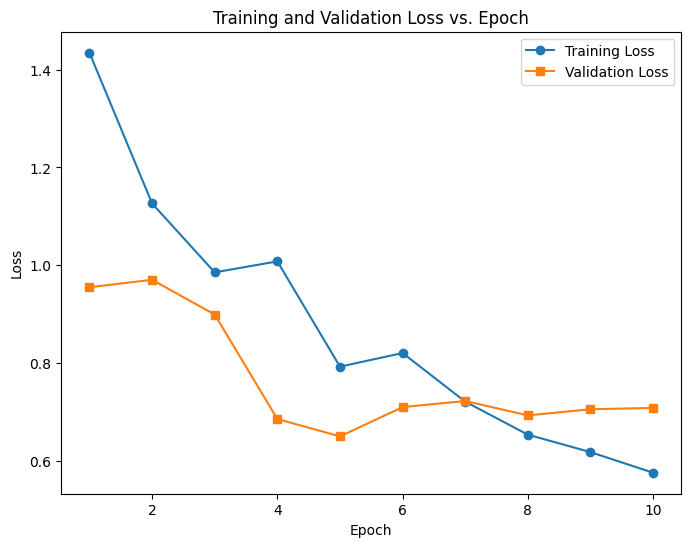

In [19]:
# Setup and Retrain
new_model = resnet18(pretrained=True)
num_features = new_model.fc.in_features
new_model.fc = nn.Linear(num_features, 10)
new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train
train_losses = train_with_fgsm(new_model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

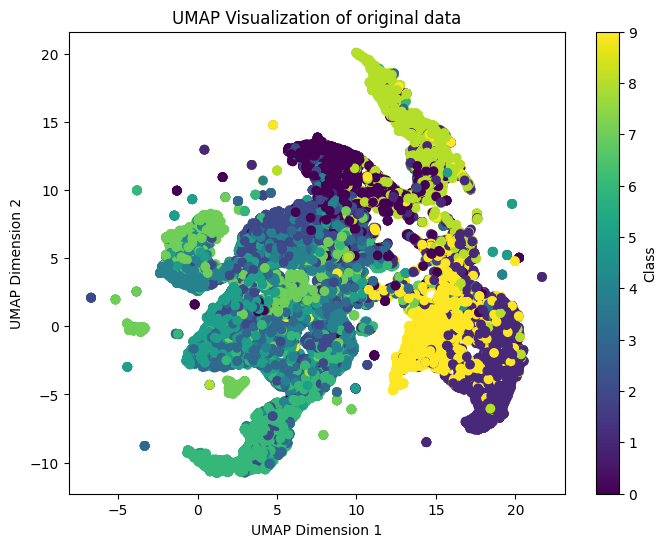

In [37]:
# Call the function to extract and visualize features
plot_umap(new_model, train_loader, device)

### 2.2. FGSM

In [32]:
new_model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(new_model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 2.3. Test agumented data/Cross entropy

In [33]:
# KNN test
train_features, train_labels = extract_features(new_model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(new_model, knn_classifier, test_loader)
test_model_adversarial_knn(new_model, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 61.09%
Accuracy on adversarial test data using KNN: 32.57%


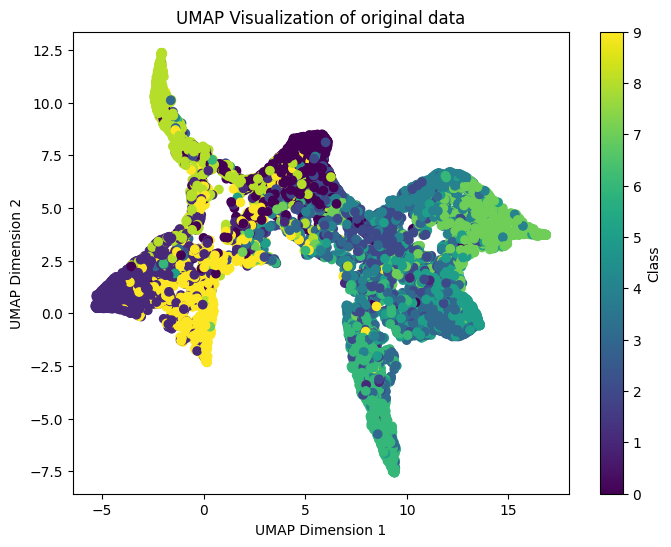

In [34]:
# Call the function to extract and visualize features
plot_umap(new_model, test_loader, device)

# 3. Original data/Circle loss

### 3.1. Optimum values of the Circle loss

### 3.2. Train original data/Circle loss

In [42]:
# Setup and Retrain
new_model2 = resnet18(pretrained=True)
num_features = new_model2.fc.in_features
new_model2.fc = nn.Linear(num_features, 128)
new_model2 = new_model2.to(device)

criterion = losses.CircleLoss(m=0.4, gamma=80)
optimizer = optim.Adam(new_model2.parameters(), lr=0.001)

# Train
train_losses_circle = train(new_model2, train_loader, val_loader, criterion, optimizer, device, num_epochs)

Epoch [1/10], Training Loss: 0.0059, Training Accuracy: 0.07%, Validation Loss: 0.0000, Validation Accuracy: 0.08%


KeyboardInterrupt: 

### 3.3. FGSM

In [ ]:
new_model2.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(new_model2, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 3.4. Test original data/Circle loss

In [ ]:
# KNN test
train_features, train_labels = extract_features(new_model2, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)


test_model_knn(new_model2, knn_classifier, test_loader)
test_model_adversarial_knn(new_model2, knn_classifier, adversarial_images, labels, device)